In [4]:
dataverse_path='/Users/jessicasun/Desktop/research files/cones dataverse/data'

In [5]:
import numpy as np
import pandas as pd
import os
import itertools as it
import trackpy as tp
import matplotlib as mpl
from matplotlib import pyplot as plt
from natsort import natsorted
from matplotlib import cm
from skimage import io, exposure
from skimage.measure import label, regionprops_table
from skimage.color import rgb2gray, gray2rgb
from scipy import ndimage as ndi
from scipy.ndimage import binary_opening, binary_closing, binary_erosion, binary_dilation, rotate, gaussian_filter
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.transform import resize
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull, Delaunay
from scipy.spatial.distance import cdist,pdist

In [25]:
print('import unwrapped images without annotations or masking')
dirpath=dataverse_path+'/'
filename_list=[]
for filename in os.listdir(dataverse_path+'/all grains/masked grains/'):
    if filename.endswith('.png'):
        filename_list+=[filename]
filename_list=natsorted(filename_list)
filename_idx=37

import unwrapped images without annotations or masking


test a MANUALLY PROCESSED image
since we have manual particle center inputs (ROIs in FIJI cross-checked with raw stack), need to preprocess
import images
import files_df.pkl and construct the binary image of a single half-period
find im_top and im_bot using unwrapped image
filter image by selecting only the period (or half-period) of interest
locate points in trackpy


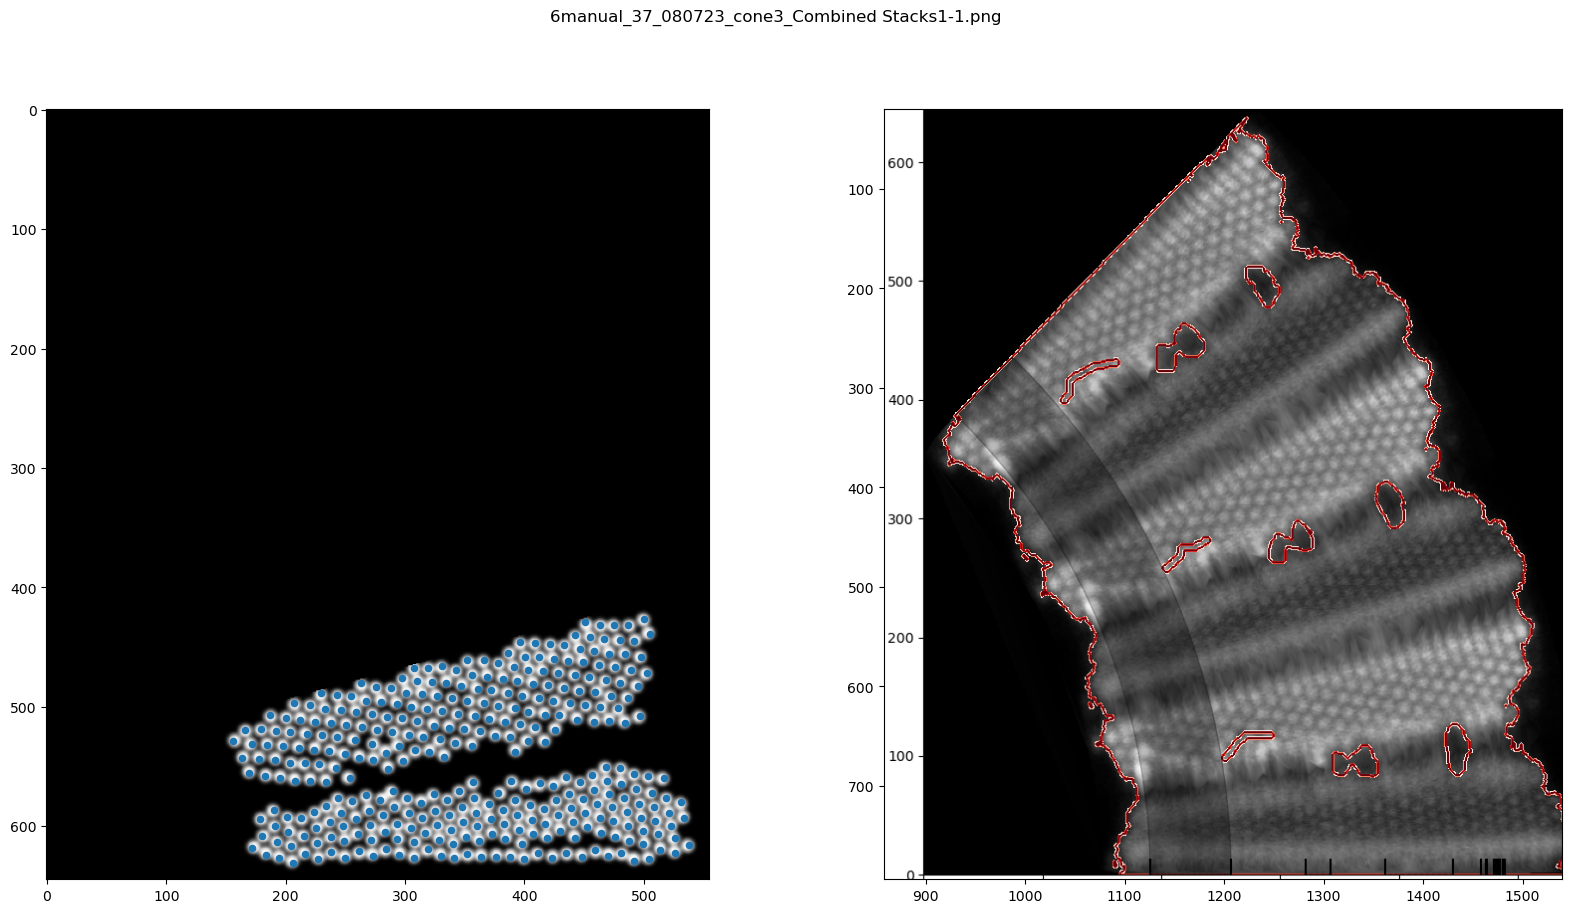

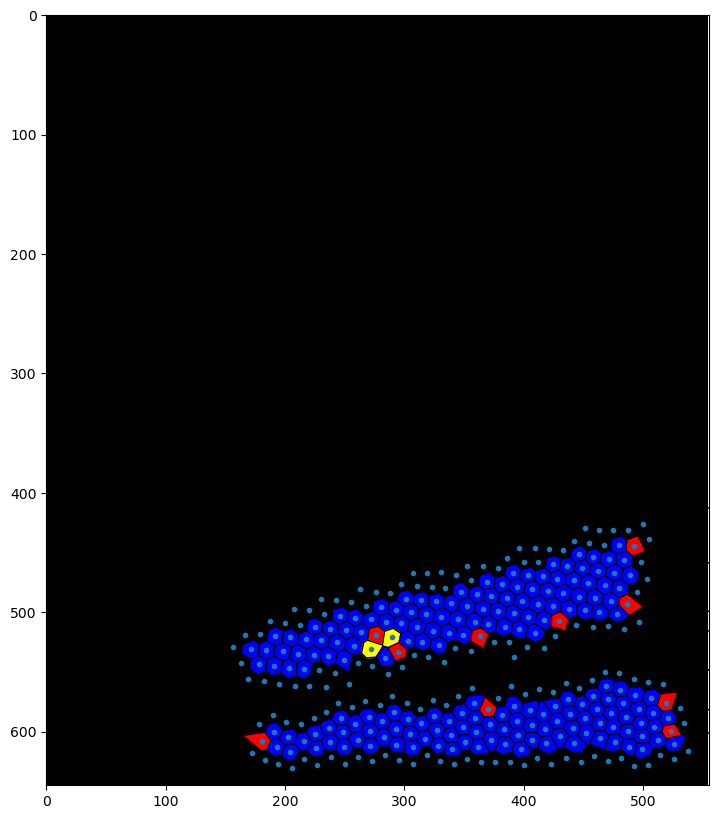

In [34]:
def get_voronoi_manual(im,im2,filename_idx=filename_idx,filename_list=filename_list):
    phi_remove=0.075 #specify how much of the half period you want to not be filled in with polygon color
    area_cutoff=1000 #area of polygon that we should fill, above which we leave empty
    perimeter_cutoff=200 #perimeter of polygon we should fill, above which we leave empty
    maxedge_cutoff=25 #max length of polygon edge, above which we leave empty
    minedge_cutoff=0 #min length of polygon edge, below which we leave empty
    
    print('import images')
    im_dim=np.shape(im)
    files_df_idx=filename_idx
    
    print('import files_df.pkl and construct the binary image of a single half-period')
    im_sector=np.flipud(im)
    files_df=pd.read_pickle(dirpath+'files_df.pkl')  
    origin_x=files_df.iloc[files_df_idx]['origin_x']
    origin_y=files_df.iloc[files_df_idx]['origin_y']

    print('find im_top and im_bot using unwrapped image')
    ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
    ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
    ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))
    
    im_top_df=ref_df[(ref_df['phi']>=0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))]
    im_bot_df=ref_df[(ref_df['phi']>=0*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                         &(ref_df['phi']<0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                         &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                         &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))]

    phi_remove_df=ref_df[(
        ((ref_df['phi']>=(-phi_remove+1)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove+1)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
        |((ref_df['phi']>=(-phi_remove+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
        |((ref_df['phi']>=(-phi_remove+0)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove+0)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
    )
        &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
        &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant

    im_top_binary=np.zeros(np.shape(im_sector))
    for im_top_idx in range(len(im_top_df)):
        x=int(im_top_df.iloc[im_top_idx]['x']+origin_x)
        y=int(im_top_df.iloc[im_top_idx]['y']+origin_y)
        im_top_binary[y,x]=1
    im_bot_binary=np.zeros(np.shape(im_sector))
    for im_bot_idx in range(len(im_bot_df)):
        x=int(im_bot_df.iloc[im_bot_idx]['x']+origin_x)
        y=int(im_bot_df.iloc[im_bot_idx]['y']+origin_y)
        im_bot_binary[y,x]=1  
    phi_remove_binary=np.zeros(np.shape(im_sector))        
    for phi_remove_idx in range(len(phi_remove_df)): #the segment between top and bottom half-periods that we want to filter out later
        x=int(phi_remove_df.iloc[phi_remove_idx]['x']+origin_x)
        y=int(phi_remove_df.iloc[phi_remove_idx]['y']+origin_y)
        phi_remove_binary[y,x]=1      
    phi_remove_binary=np.flipud(phi_remove_binary) # 1 (white) represents what we want to REMOVE. will use later in voronoi to decide what polygons to fill.
    ycoord,xcoord=np.where(phi_remove_binary==1)
    phi_remove_coord=list(zip(xcoord,ycoord)) #note: these coordinates are all integers
    print('filter image by selecting only the period (or half-period) of interest') #mask the image itself.   
    im=np.flipud(im_sector*(im_top_binary+im_bot_binary)) #select period
    
    print('locate points in trackpy')
    points_df=tp.locate(im,diameter=(7,7))
    points=np.array(list(zip(points_df['x'],points_df['y'])))

    fig,axs=plt.subplots(ncols=2,figsize=(20,10))
    fig.suptitle(impath.split('/')[-1])
    ax=axs[0]
    ax.scatter(points[:,0],points[:,1],s=20)
    ax.imshow(im,cmap="Greys_r")
    #######
    #######
    ax=axs[1]
    ax.imshow(im2,cmap="Greys_r")

    # print('find bounding box of the wc band image')
    im2_gray=1-rgb2gray(im2[:,:,:3])
    im2_binary=binary_erosion(binary_dilation(im2_gray>0.9,iterations=25),iterations=20)
    selected=(label(im2_binary)==2)*2
    bbox=regionprops_table(selected,properties=['bbox']) #get bounding box of the banded image
    xlim_bbox=[*bbox['bbox-1'],*bbox['bbox-3']]
    ylim_bbox=[*bbox['bbox-0'],*bbox['bbox-2']]

    ax.set_ylim(ylim_bbox)
    ax.set_xlim(xlim_bbox)
    ax.invert_yaxis()
    plt.savefig(dirpath+'all grains/voronoi/voronoi_images/input-'+filename_list[filename_idx],bbox_inches='tight', pad_inches=0)    
    #######
    #######
    # print('find voronoi cells')
    vor=Voronoi(points)
    
    # print('plot voronoi cells')
    fig,ax=plt.subplots(1,figsize=(10,10))
    voronoi_plot_2d(vor,ax=ax,line_width=1,show_points=True,show_vertices=False)

    # print('fill cell colors')
    cell_list=vor.point_region #list of cell labels
    # print('select a polygon cell')    
    for cell_idx in range(len(cell_list)):
        cell_label=cell_list[cell_idx]
        cell_x=points[cell_idx][0]
        cell_y=points[cell_idx][1]
        vert_list = vor.regions[cell_label]
        edge_list= vor.ridge_vertices
        if not -1 in vert_list: #-1 means vertex not in diagram
            # print('get list of vertex labels for the polygon')
            vert_label_list=[vert_list[vert_idx] for vert_idx in range(len(vert_list))] #list of vertex labels in the polygon
            # print('get list of edges (tuples of vertex labels) for the polygon')
            edge_list=[]
            for edge_tuple in vor.ridge_vertices: #for all edges in the image
                if set(edge_tuple).issubset(vert_label_list): #check if the edge is in selected polygon
                    edge_list+=[edge_tuple] #list of polygon edges
            # print('get list of edge lengths for the polygon')
            edge_dist_list=[]
            for edge in edge_list:
                edge_coord = [vor.vertices[vert_label] for vert_label in edge]
                edge_dist = pdist(edge_coord)
                edge_dist_list+=[*edge_dist]
            # print('get list of vertex coordinates for the polygon')
            polygon = [vor.vertices[vert_label] for vert_label in vert_label_list] #list of vertex coordinates in the polygon
            # print('decide if we should fill the cell')
            fill=1      
            for vertex_coord in polygon:
                vertex_coord=tuple(vertex_coord.astype(int))
                if vertex_coord in phi_remove_coord: #check if polygon vertex is in phi_remove_coord
                    fill=0 #if ANY of the coordinates are in phi_remove_coord, then fill=0
                    
            polygon_area=ConvexHull(polygon).volume #area of polygon
            polygon_perimeter=ConvexHull(polygon).area #perimeter of polygon     
            polygon_maxedge=max(edge_dist_list)
            polygon_minedge=min(edge_dist_list)
            cutoff_criteria=(polygon_area<=area_cutoff)&(polygon_perimeter<=perimeter_cutoff)&(polygon_maxedge<=maxedge_cutoff)&(polygon_minedge>=minedge_cutoff)
            if (cutoff_criteria)&(fill==1):
                color_dict={3:'purple',4:'purple',5:'red',6:'blue',7:'yellow',8:'purple',9:'purple',10:'purple',11:'purple',12:'purple'}
                try:
                    polygon_color=color_dict[len(polygon)]
                except:
                    polygon_color='None'
                plt.fill(*zip(*polygon), color=polygon_color) #len(polygon) = # of vertices = # of edges
    ax.imshow(im<0,cmap='Greys_r')

    ax.set_ylim([0,im_dim[0]])
    ax.set_xlim([0,im_dim[1]])

    ax.invert_yaxis()   
    plt.savefig(dirpath+'all grains/voronoi/voronoi_images/'+filename_list[filename_idx],bbox_inches='tight', pad_inches=0)
    plt.savefig(dirpath+'all grains/voronoi/voronoi_images/'+filename_list[filename_idx][:-4]+'.svg',bbox_inches='tight', pad_inches=0)    
    return vor
    
print('test a MANUALLY PROCESSED image')
filename_idx=37
impath=dirpath+'all grains/voronoi/voronoi_ref/6manual_37_080723_cone3_Combined Stacks1-1.png' #8-bit image
impath2=dirpath+'all grains/bands/'+filename_list[filename_idx]

im=io.imread(impath)
im2=io.imread(impath2)

print('since we have manual particle center inputs (ROIs in FIJI cross-checked with raw stack), need to preprocess')
im=gaussian_filter((im>250)*im,sigma=2)
vor=get_voronoi_manual(im,im2)

fraction of period to remove from top (clear) image: 0.125 0.125
fraction of period to remove from bot (underside) image: 0.175 0.175


find the delaunay triangulation of the particle centers (this should produce the dual graph of the voronoi diagram
remove nonsense points - generate fill column to decide which points to fill
remove nonsense edges - generate column in edges_df to decide which to plot
manually remove extra bonds at half periods in inkscape


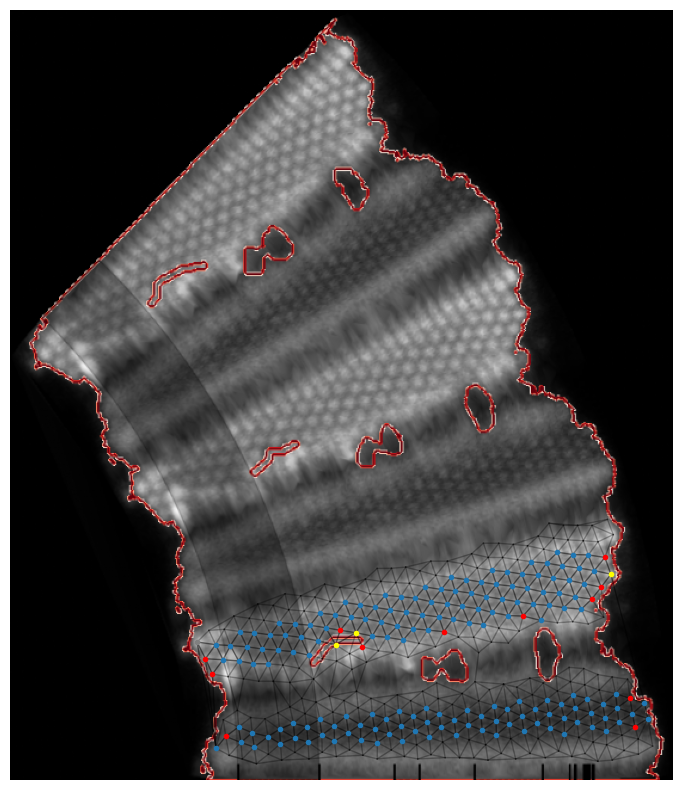

In [36]:
phi_remove_top=float(input('fraction of period to remove from top (clear) image: 0.125')) #specify how much of the half period you want to not be filled in with polygon color
phi_remove_bot=float(input('fraction of period to remove from bot (underside) image: 0.175')) #additional removal for bottom half period bc of reduced image quality
print('find the delaunay triangulation of the particle centers (this should produce the dual graph of the voronoi diagram')
def get_neighbor_vertex_ids_from_vertex_id(vertex_id, tri): #https://stackoverflow.com/a/53580736
    index_pointers, indices = tri.vertex_neighbor_vertices
    result_ids = indices[index_pointers[vertex_id]:index_pointers[vertex_id + 1]]
    return result_ids

impath3=dirpath+'all grains/voronoi/voronoi_ref/3unwrapped_37_080723_cone3_Combined Stacks1-1.png'
impath4=dirpath+'all grains/bands/ref/37_080723_cone3_Combined Stacks1-1.png'
im3=io.imread(impath3)
im4=io.imread(impath4)
im4 = resize(im4, (im3.shape[0],im3.shape[1]),anti_aliasing=True)

points=vor.points
tri=Delaunay(points)

points=tri.points

points_df=[]
for point_idx in range(len(points)):
    point=points[point_idx]
    neighbors=get_neighbor_vertex_ids_from_vertex_id(point_idx,tri)
    coordnum=len(neighbors)
    points_df+=[pd.DataFrame([{'point':point,'point_x':point[0],'point_y':point[1],'coordnum':coordnum}])]
points_df=pd.concat(points_df).reset_index(drop=True)

print('remove nonsense points - generate fill column to decide which points to fill')
# phi_remove=0.1 #specify how much of the half period you want to not be filled in with polygon color
im_dim=np.shape(im)
files_df_idx=filename_idx

im_sector=np.flipud(im)
files_df=pd.read_pickle(dirpath+'files_df.pkl')  
origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']

ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))
phi_remove_df=ref_df[(
    ((ref_df['phi']>=(-phi_remove_top+1)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove_top+1)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
    |((ref_df['phi']>=(-phi_remove_bot+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove_top+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
    |((ref_df['phi']>=(-phi_remove_bot+0)*np.abs(files_df['sectorangle'].iloc[files_df_idx]))&(ref_df['phi']<(phi_remove_bot+0)*np.abs(files_df['sectorangle'].iloc[files_df_idx])))
)
    &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
    &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
                     # &(ref_df['phi']>=(-phi_remove+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     # &(ref_df['phi']<(phi_remove+0.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     # &(ref_df['phi']>=(-phi_remove+1.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     # &(ref_df['phi']<(phi_remove+1.5)*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period

phi_remove_binary=np.zeros(np.shape(im_sector))        
for phi_remove_idx in range(len(phi_remove_df)): #the segment between top and bottom half-periods that we want to filter out later
    x=int(phi_remove_df.iloc[phi_remove_idx]['x']+origin_x)
    y=int(phi_remove_df.iloc[phi_remove_idx]['y']+origin_y)
    phi_remove_binary[y,x]=1      
phi_remove_binary=np.flipud(phi_remove_binary) # 1 (white) represents what we want to REMOVE. will use later in voronoi to decide what polygons to fill.
ycoord,xcoord=np.where(phi_remove_binary==1) #note: if too many values to unpack, make sure the input (6manual..) image is 8-bit
phi_remove_coord=list(zip(xcoord,ycoord)) #note: these coordinates are all integers

fill_list=[]
for idx in range(len(points_df)):
    point=tuple(points_df['point'].iloc[idx].astype(int))
    if point in phi_remove_coord: #check if polygon vertex is in phi_remove_coord
        fill_list+=[0] #if ANY of the coordinates are in phi_remove_coord, then fill=0    
    else:
        fill_list+=[1]
points_df['fill']=fill_list

print('remove nonsense edges - generate column in edges_df to decide which to plot')
def less_first(a, b): #https://stackoverflow.com/questions/69512972/how-to-generate-edge-index-after-delaunay-triangulation
    return [a,b] if a < b else [b,a]
def delaunay2edges(tri):
    list_of_edges = []
    for triangle in tri.simplices:
        for e1, e2 in [[0,1],[1,2],[2,0]]: # for all edges of triangle
            list_of_edges.append(less_first(triangle[e1],triangle[e2])) # always lesser index first
    array_of_edges = np.unique(list_of_edges, axis=0) # remove duplicates
    list_of_lengths = []
    for p1,p2 in array_of_edges:
        x1, y1 = tri.points[p1]
        x2, y2 = tri.points[p2]
        list_of_lengths.append((x1-x2)**2 + (y1-y2)**2)
    array_of_lengths = np.sqrt(np.array(list_of_lengths))
    return array_of_edges, array_of_lengths
edges, lengths = delaunay2edges(tri)

edges_df=pd.DataFrame([])
edges_df['length']=lengths
edges_df['edge1']=edges[:,0]
edges_df['edge2']=edges[:,1]
edges_df['point1_x']=points[edges[:,0]][:,0]
edges_df['point1_y']=points[edges[:,0]][:,1]
edges_df['point2_x']=points[edges[:,1]][:,0]
edges_df['point2_y']=points[edges[:,1]][:,1]

fill_list=[]
for idx in range(len(edges_df)): #phi_remove_coord listed as int
    x1,y1,x2,y2=edges_df['point1_x'].iloc[idx].astype(int),edges_df['point1_y'].iloc[idx].astype(int),edges_df['point2_x'].iloc[idx].astype(int),edges_df['point2_y'].iloc[idx].astype(int)
    point1=(x1,y1)
    point2=(x2,y2)
    if (point1 in phi_remove_coord)|(point2 in phi_remove_coord): #check if polygon vertex is in phi_remove_coord
        fill_list+=[0] #if ANY of the coordinates are in phi_remove_coord, then fill=0    
    else:
        fill_list+=[1]
edges_df['fill']=fill_list
#####
#####
#####
fig,ax=plt.subplots(1,figsize=(10,10))
filtered_edges=edges_df[edges_df['fill']==1]
x1,x2,y1,y2=filtered_edges['point1_x'].values,filtered_edges['point2_x'].values,filtered_edges['point1_y'].values,filtered_edges['point2_y'].values
for idx in range(len(filtered_edges)):
    plt.plot([x1[idx],x2[idx]],[y1[idx],y2[idx]], color='black',linewidth=1,alpha=0.5)
filtered_edges=edges_df[(edges_df['fill']==0)&(edges_df['length']<=30)]
x1,x2,y1,y2=filtered_edges['point1_x'].values,filtered_edges['point2_x'].values,filtered_edges['point1_y'].values,filtered_edges['point2_y'].values
for idx in range(len(filtered_edges)):
    plt.plot([x1[idx],x2[idx]],[y1[idx],y2[idx]], color='black',linewidth=1,alpha=0.3)    
# plt.triplot(points[:,0], points[:,1], tri.simplices,color='black',linewidth=1,alpha=0.5)
# plt.plot(points_df['point_x'], points_df['point_y'], '.')

preprocess_df=points_df[points_df['fill']==1]
filtered_df=preprocess_df[preprocess_df['coordnum']==6]
plt.plot(filtered_df['point_x'], filtered_df['point_y'], '.',color='C0')
filtered_df=preprocess_df[preprocess_df['coordnum']==5]
plt.plot(filtered_df['point_x'], filtered_df['point_y'], '.',color='red')
filtered_df=preprocess_df[preprocess_df['coordnum']==7]
plt.plot(filtered_df['point_x'], filtered_df['point_y'], '.',color='yellow')
filtered_df=preprocess_df[(preprocess_df['coordnum']<5)|(preprocess_df['coordnum']>7)]
plt.plot(filtered_df['point_x'], filtered_df['point_y'], '.',color='gray')

plt.imshow(im4)
ax.axis('off')

plt.savefig(dirpath+'all grains/voronoi/voronoi_images/delaunay-'+filename_list[filename_idx],bbox_inches='tight', pad_inches=0)
plt.savefig(dirpath+'all grains/voronoi/voronoi_images/delaunay-'+filename_list[filename_idx][:-4]+'.svg',bbox_inches='tight', pad_inches=0)    

print('manually remove extra bonds at half periods in inkscape')